In [59]:
# toolbox.py --------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, GPT2LMHeadModel, PhrasalConstraint

from analysis.toolbox import *

import time
import pickle
import io
import os

import mlflow

def load_data(sDataPath):
    with open(sDataPath, 'r') as file:
        lClaims = file.readlines()
    lClaims = [claim.replace('\n', '') for claim in lClaims]
    return lClaims

# GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


torch.set_default_device(device)

print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)

s_model = "gpt2"
iSeed = 4523522
sPadding = "left"
torch.manual_seed(iSeed)

model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True)
tokenizer = AutoTokenizer.from_pretrained(s_model, resume_download=True)

if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

Using mps device
mps:0


In [60]:
class AutoencoderDeep(nn.Module):
   def __init__(self, input_size, encoding_dim, output_size):
       super(AutoencoderDeep, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, 192, bias=True),
           nn.LeakyReLU(negative_slope=0.01, inplace=False),
           nn.Linear(192, 48, bias=True),
           nn.LeakyReLU(negative_slope=0.01, inplace=False),
           nn.Linear(48, encoding_dim, bias=True)
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, output_size, bias=True)
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

In [61]:
lTargetStrings = load_data("hair20.txt")
tTargetStrings, lLengths = TokenizeClaims(lTargetStrings, tokenizer)
iMaxTokens = max(lLengths)
iClaims = len(lTargetStrings)
tInputData = create_input_data(len(lTargetStrings))

fn_generate = lambda x: model.generate(
    inputs_embeds = x,
    do_sample = False,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens=iMaxTokens,
    num_beams=20,
    return_dict_in_generate=True
)

In [62]:
ae = Autoencoder(len(lTargetStrings), 2, 768)
# ae = AutoencoderDeep(768, 2, 768)
ae.load_state_dict(torch.load("state_dict_FactorModel_hair20.pt", map_location=torch.device('mps')))

<All keys matched successfully>

In [44]:
# tInputData = model.get_input_embeddings()(tTargetStrings).mean(dim=1)

In [63]:
tSummaryEmbeddingPred = ae(tInputData).unsqueeze(1)# generate iMaxTokens + 1 to account for EOS of longest claim
lGenNew = model.generate(inputs_embeds = tSummaryEmbeddingPred, max_new_tokens = iMaxTokens + 1, pad_token_id = tokenizer.pad_token_id, num_beams = 1)
for i in range(iClaims):
    print(f"Claim {i + 1}: {tokenizer.decode(lGenNew[i])}")
    print(f"Orig. {i + 1}: {tokenizer.decode(tTargetStrings[i].tolist())}")
    
    if not torch.all(lGenNew[i] == tTargetStrings[i]):
        print(f"MISMATCH between original and generated claim! See claim {i + 1}")

Claim 1: Experience 50% more visible shine after just one use.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Orig. 1: Experience 50% more visible shine after just one use.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim 2: Formulated with light-reflecting technology for a glossy finish.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Orig. 2: Formulated with light-reflecting technology for a glossy finish.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim 3: Transform dull strands into radiant, luminous locks.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Orig. 3: Transform dull strands into radiant, luminous locks.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Claim 4: Infused with nourishing oils that enhance natural shine.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Orig. 4: Infused

In [64]:
from scipy.spatial import ConvexHull
import difflib

def find_closest_string(target_string, string_list):
    closest_match = difflib.get_close_matches(target_string, string_list, n=1, cutoff=0.2)
    if closest_match:
        closest_index = string_list.index(closest_match[0])
        
        return closest_match[0], closest_index
    else:
        return None, None
    
def get_halfway_point(tA, tB, dWeight = 0.5):
    return (dWeight * tA + (1 - dWeight) * tB)

In [65]:
encoded_data = ae.encoder(tInputData).detach().cpu().numpy()
tencoded_data = ae.encoder(tInputData)
fn_gen_new = lambda x: model.generate(inputs_embeds = ae.decoder(x).reshape(1, 1, -1), max_new_tokens = iMaxTokens + 10, pad_token_id = tokenizer.pad_token_id, num_beams = 20)

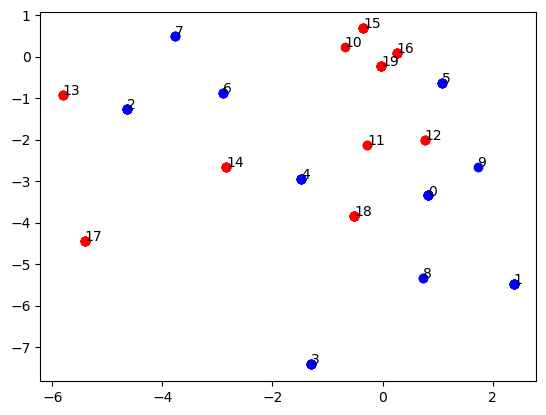

In [66]:
for i in range(iClaims):
    if i < iClaims / 2:
        plt.plot(encoded_data[0:(i + 1), 0], encoded_data[0:(i + 1), 1], "o", color = "blue")
    else:
        plt.plot(encoded_data[i:, 0], encoded_data[i:, 1], "o", color = "red")
        
for i, txt in enumerate(range(iClaims)):
    plt.plot(encoded_data[i, 0], encoded_data[i, 1])
    plt.annotate(txt, (encoded_data[i, 0], encoded_data[i, 1]))

In [68]:
lTargetStrings[1], lTargetStrings[4], lTargetStrings[18], lTargetStrings[10]

('Formulated with light-reflecting technology for a glossy finish.',
 'See instant brilliance with our advanced shine-boosting formula.',
 'Experience the magic of hair that dazzles with every movement.',
 'Elevate your confidence with hair that gleams under any light.')

In [71]:
import difflib
def find_closest_string(target_string, string_list):
    
    if "<|endoftext|>" not in target_string[-13:]:
        return None, None, None
    
    else:
    
        closest_match = difflib.get_close_matches(target_string[:-13], string_list, n=1, cutoff=0.999)
        if closest_match:
            closest_index = string_list.index(closest_match[0])
            similarity_ratio = difflib.SequenceMatcher(None, target_string, closest_match[0]).ratio()
            
            return closest_match[0], closest_index, similarity_ratio
        
        else:
            return None, None, None

def find_new_string(target_string, string_list):
    
    if "<|endoftext|>" not in target_string[-13:]:
        return False
    
    else:
    
        closest_match = difflib.get_close_matches(target_string[:-13], string_list, n=1, cutoff=1)

        if closest_match:
            return False
        
        else:

            print(f"New string: {target_string}")
            return True
        
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step

new_valid_strings = []
closest_matches = []
lPoints = []

step_x = 0.25
step_y = 0.25
min_x = -7
max_x = 3
min_y = -8
max_y = 2
lGeneratedStrings = []
for x in drange(min_x, max_x, step_x):
    for y in drange(min_y, max_y, step_y):
        point = torch.tensor([x, y], dtype=torch.float32)
        lPoints.append(point.detach().cpu().numpy())
        generated_string = tokenizer.decode(fn_gen_new(point)[0])
        lGeneratedStrings.append(generated_string)
        
        closest_string, closest_index, distance_measure = find_closest_string(generated_string, lTargetStrings)
        
        if closest_string is None: 
            closest_index = -1
        
        closest_matches.append((point, closest_index, distance_measure))
        new_valid_strings.append(find_new_string(generated_string, lTargetStrings))

New string: Step intoakingakingakingirectionirectionirectionirectionirection<|endoftext|>
New string: Step intoakingakingakingirectionirectionirectionirectionirection<|endoftext|>
New string: Step intoakingakingakingakingirectionirectionirectionirectionirection<|endoftext|>
New string: Step intoakingakingakingakingirectionirectionirectionirectionirection<|endoftext|>
New string: Step intoakingakingakingakingirectionirectionirectionirectionirectionirection<|endoftext|>
New string: Step intoakingakingakingakingirectionirectionirectionirectionirectionirection<|endoftext|>
New string: Step intoakingakingakingakingirectionirectionirectionirectionirectionirectionirection<|endoftext|>
New string: Step into the at the end<|endoftext|>
New string: Transform your OWN BRAIN<|endoftext|>
New string: Transform your OWN BRAIN<|endoftext|>
New string: Transform your OWN BRAIN<|endoftext|>
New string: Transform your OWN BRAKEATHATHATHATHATHATH
<|endoftext|>
New string: Transform your profile with exen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indent
"
"
"
"
"

"

"

"

"




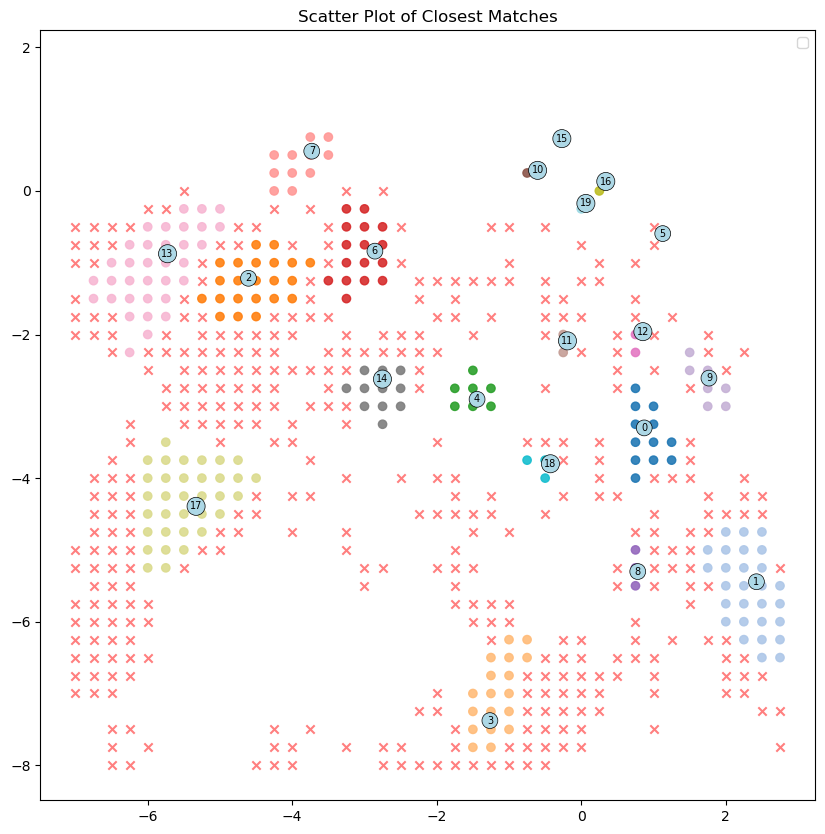

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Extract the x and y coordinates from closest_matches
x_coords = np.asarray([point[0][0].item() for point in closest_matches])
y_coords = np.asarray([point[0][1].item() for point in closest_matches])

# Extract the closest_index values
colors = [point[1] for point in closest_matches]
similarity_ratio = [similarity_ratio[2] for similarity_ratio in closest_matches]

# Plot the scatter plot
vNull = np.asarray(colors) == -1
vNew = np.asarray(new_valid_strings)

tPoint = torch.tensor([0, 0], dtype=torch.float32)
print(tokenizer.decode(fn_gen_new(tPoint)[0]))

# cmap="hsv"
plt.scatter(x_coords[vNull], y_coords[vNull], c="white", marker=".", alpha=0.2)
plt.scatter(x_coords[~vNull], y_coords[~vNull], c=np.asarray(colors)[~vNull], marker="o", alpha=np.asarray(similarity_ratio)[~vNull], cmap="tab20")
plt.scatter(x_coords[vNew], y_coords[vNew], c="red", marker="x", alpha=0.5)
#plt.scatter(encoded_data[:, 0], encoded_data[:, 1], marker="x", c = range(len(lTargetStrings)), cmap="tab20")


# # Compute the convex hull
# hull = ConvexHull(encoded_data)

# # Plot the convex hull
# for simplex in hull.simplices:
#     plt.plot(encoded_data[simplex, 0], encoded_data[simplex, 1], '--', c="grey")

for i, txt in enumerate(range(encoded_data.shape[0])):
    plt.annotate(txt, (encoded_data[i, 0], encoded_data[i, 1]), size = 7, bbox=dict(boxstyle="circle",
                      fc="lightblue", lw=0.5))
    
#plt.plot(tPoint.cpu().detach().numpy()[0], tPoint[1].cpu().detach().numpy(), 'rx', c="black")


# Add labels and title
plt.title('Scatter Plot of Closest Matches')
plt.legend()
# Show the plot
plt.show()